
## Using machine learning to classify phase behavior of a surfactant/oil system

#### Tongzhou Zeng
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

* Phase behavior is essential in chemical EOR process. A intermediate microemulsion layer is desired when mixing oil with surfactant solution.

* However, investigating phase behavior is very tedious and the selection of chemical for testing is 100% experience based.

* For this workflow, a machine learning classifier is trained to predict the phase behavior result (show microemulsion vs non-microemulsion) given oil and surfactant compositions, with a P-R AUC around 0.8.

* We can use this model to get an idea of possible outcome before performing the tedious lab screening process.

### Import Packages

In [1]:
# first import machine learning libraries used in almost any workflows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA    # PCA for feature building
from sklearn.cluster import KMeans       # K-mean clustering for feature building
from sklearn.model_selection import train_test_split # split training/test set
from sklearn.linear_model import LogisticRegression  # LR method
from sklearn.ensemble import RandomForestClassifier  # RF method
from sklearn.preprocessing import StandardScaler, MinMaxScaler # normalization

from sklearn.model_selection import GridSearchCV  # for hyperparameter tuning
from sklearn import metrics  # for plotting the model results

### Functions

for plotting the results of a model.

For this work, two evaluation metrics are mainly considered: the **accuracy** and the **PR AUC**. Since this is a binary classification, the accuracy is what I care. However, even though my y-label is not very unbalanced (13:7), accuracy will be biased as long as the y-label is not perfectly balanced. Therefore, the AUC of the precision-recall curve is also taken into account. Here I choose PR AUC over ROC AUC, because I do have a preference of true positives over true negatives in this context. I choose PR AUC over precision only or recall only, because I do care both type I and type II errors.

In [2]:
def present_result(y_true, y_pred, y_pred_proba):
    # print out the results of evaluation metrics
    # y_true is the true label
    # y_pred is the predicted label
    # y_pred_proba is the probability of predicting 1
    cm = metrics.confusion_matrix(y_true, y_pred)
    #print(cm)
    fig,ax=plt.subplots()
    sns.heatmap(cm,
            annot=True, fmt='g',
            cmap="Blues")
    ax.set_ylim([0,2])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    print('accuracy: ', np.round((cm[0][0] + cm[1][1]) / np.sum(np.sum(cm)),3))
    #print('precision: ', cm[1][1]/(cm[0][1] + cm[1][1]) )
    #print('recall: ', cm[1][1]/(cm[1][0] + cm[1][1]) )
    #fpr, tpr, thresholds = metrics.roc_curve(y_vali, y_predprob)
    #print('ROC AUC: ', metrics.auc(fpr, tpr))
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_proba)
    print('PR AUC: ', np.round(metrics.auc(recall, precision),3))

### Load Data

The data set used for the following workflow is parsed from the phase behavior database build by Leonard Chang. The dataset will NOT be released.

We will work with the following tables:

* **ML_FinalProject_F20_Tongzhou Zeng_data_1.csv** - Parsed phase behavior data, just including oil name, surfactant composition and concentrations.
* **ML_FinalProject_F20_Tongzhou Zeng_data_2.csv** - The property for each of the oil
* **ML_FinalProject_F20_Tongzhou Zeng_data_3.csv** - The property for each of the surfactant/co-solvents 

Note: In this workflow, all three tables are going to be further processed. The processed tables are also included when submitting this project for easy access, but they will be generated during the workflow.

In [3]:
df_pb = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_1.csv',index_col = 0)
df_oil = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_2.csv',index_col = 0)
df_chem = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_3.csv', index_col = 0)

We first visualize each of the tables.

For **chemical_properties** table, it contains 263 rows and 10 columns.
* **issurf** - 1 for surfactant, 0 for co-solvents
* **NC** - number of carbon in the chain
* **NEO** - number of EO group in the molecule
* **NPO** - number of PO group in the molecule
* **HG_XXX** - One hot encoded for headgroup
* **cnt** - occurance frequency

In [4]:
df_chem.head()

,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt
Surf_1,1,12.4,0.0,0.0,0,0,1,0,0,1
Surf_2,1,20.0,0.0,0.0,0,0,1,0,0,1
Surf_3,1,16.0,0.0,0.0,0,0,1,0,0,2
Surf_4,1,20.0,0.0,0.0,0,0,1,0,0,2
Surf_5,1,11.7,0.0,0.0,0,0,1,0,0,3


For **oil_property** table, it contains 161 rows and 6 columns.
* **MW** - Molar weight of oil, g/mol
* **EACN** - Effective ACN for oil
* **Vm** - molar volume, cm3/mol
* **density** - density, g/cm3
* **TAN** - Total acid number
* **active** - 1 for active, 0 for non-active

In [5]:
df_oil.head()

,MW,EACN,Vm,density,TAN,active
Oil_1,230.000000,10.000000,283.513097,0.811250,0.100,0
Oil_1 + 12% Oil_L,194.990578,7.714458,238.410456,0.817878,0.088,0
Oil_2 + 21% Oil_A,NaN,NaN,NaN,NaN,0.158,0
Oil_2 + 30% Oil_A,NaN,NaN,NaN,NaN,0.140,0
Oil_3,310.000000,11.000000,353.881279,0.876000,2.080,1


For **phase_behavior** table, it contains 1990 rows and 5 columns.
* **Cat** - Column for response variable, 1 for showing microemulsion, 0 for not showing microemulsion
* **Formulation** - chemical composition and their individual weight concentration, separated by #.
* **Oil** - name of oil

In [6]:
df_pb.head()

,Cat,Formulation,Oil
0,0,0.125%#Surf_79#0.125%#Surf_15#,Oil_4
1,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4
2,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4
3,1,0.1%#Surf_52#0.1%#Surf_69#,Oil_4
4,0,0.5%#Surf_52#0.5%#Surf_69#,Oil_4


We need to look at the distribution of y-labels.

In [7]:
df_pb['Cat'].value_counts()

0    1272
1     718
Name: Cat, dtype: int64

We see that the negative to positive ratio is 13:7. It is relatively balanced, so NO up-sampling or down-sampling will be performed.

The dataset has no features in it, so I have to manually create features. The workflow contains 4 parts, which are:

* **Creating oil features**
* **Creating chemical features**
* **Train models**
* **Hyperparameter tuning**

## 1. Creating oil features

First of all, there are missing values in the oil property table. Since I cannot find any clue of the missing ones, I will just use the mean value of the column to impute it.

In [8]:
df_oil=df_oil.fillna(df_oil.mean())
df_oil.describe()

,MW,EACN,Vm,density,TAN,active
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,283.870691,12.477616,321.939496,0.861833,0.782789,0.428571
std,79.148008,3.294857,77.285502,0.036491,1.102294,0.496416
min,129.844391,5.319586,160.495813,0.766693,0.000000,0.000000
25%,222.244472,10.247879,265.579182,0.841612,0.085030,0.000000
50%,278.167489,12.460870,321.939496,0.861833,0.190000,0.000000
75%,333.508254,14.752343,359.684532,0.878515,0.997024,1.000000
max,566.413734,21.100000,580.341941,0.976000,5.140000,1.000000


Then we plot the correlation matrix to see if the features are correlated or not.

In [9]:
corr_matrix = np.corrcoef(df_oil, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[1.   0.6  0.93 0.57 0.54 0.51]
 [0.6  1.   0.62 0.03 0.41 0.33]
 [0.93 0.62 1.   0.49 0.37 0.47]
 [0.57 0.03 0.49 1.   0.29 0.24]
 [0.54 0.41 0.37 0.29 1.   0.67]
 [0.51 0.33 0.47 0.24 0.67 1.  ]]


We can see that the features are highly correlated, also we noticed that the Vm column is simply the ratio of MW over density. So to avoid multicolinearlity, I am going to use **PCA** to reduce its dimension. The data will be normalized prior to PCA.

In [10]:
# normalizing features
SC = StandardScaler()
x = SC.fit_transform(df_oil)

#performing PCA
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Now we plot the variance explained for each principal component

Variance explained 6 principle components = [0.573 0.167 0.153 0.064 0.035 0.007]


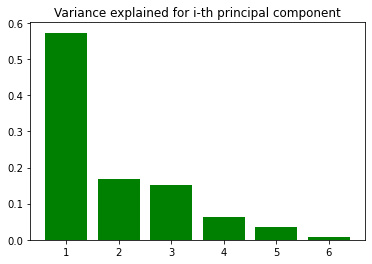

In [11]:
var_exp = np.round(pca.explained_variance_ratio_,3)

plt.bar(range(1, 7) ,var_exp,
       color="g", align="center")
plt.xticks(range(1, 7))
plt.title("Variance explained for i-th principal component")
print('Variance explained 6 principle components =', var_exp)

We can see that the first 3 components explained 90% variance, so the first three components will be used as oil features. 

In [12]:
x_trans = pca.transform(x)
x_pca_origin = SC.inverse_transform(x_trans)
for i in range(3):
    df_oil['PCA_' + str(i + 1)] = x_pca_origin[:, i]
df_oil.to_csv('ML_FinalProject_F20_Tongzhou Zeng_data_2_processed.csv')

## 2. Creating chemical features

For the chemicals, the features are all related to the molecular structure of the particles. These features are controlled by manufacturing processes, so these features are relatively independent. We first plot the histogram of the frequency of each chemical.

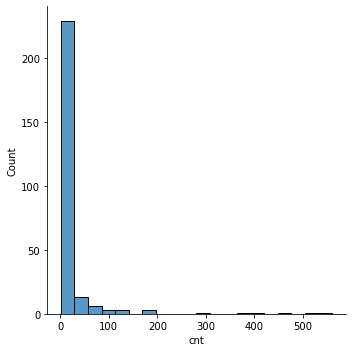

In [13]:
sns.displot(df_chem['cnt'], bins=20)

We see that the distribution is highly skewed, which means that half of the chemicals occured less than 5 times in the dataset, while several chemicals are extremely popular. I noticed that the molecue structure difference between some chemicals are small, often within the error range of the manufacturing process. 

Given the two reasons above, small difference between items but relative independent features, I will use **K-means clustering** to decrease the dimensions of chemicals. Also, by domain knowledge, surfactant and co-solvents will be treated separately

In [14]:
df_surf = df_chem[df_chem['issurf']==1]
df_cosolv = df_chem[df_chem['issurf']==0]

Like above, the features are first normalized

In [15]:
norm_scaler = MinMaxScaler()
X_surf = norm_scaler.fit_transform(df_surf.iloc[:,1:])
df_surf.iloc[:,1:] = X_surf
df_surf.describe()

C:\Users\leafblade\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt
count,214.0,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.0,0.424395,0.168336,0.294282,0.565421,0.224299,0.079439,0.023364,0.107477,0.039092
std,0.0,0.164108,0.178782,0.260427,0.496864,0.418098,0.271057,0.151412,0.310444,0.126837
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.284091,0.020000,0.011538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.454545,0.100000,0.230769,1.000000,0.000000,0.000000,0.000000,0.000000,0.003891
75%,1.0,0.545455,0.250000,0.538462,1.000000,0.000000,0.000000,0.000000,0.000000,0.023346
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we perform K-means clustering, and plot the inertia vs number of clusters

Text(0, 0.5, 'Inertia')

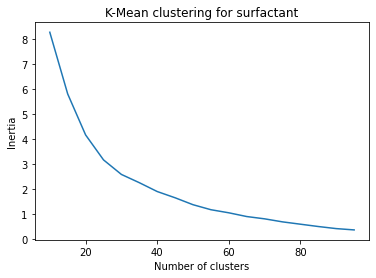

In [16]:
center_num = list(range(10,100,5))
inertia = []
for i in center_num:
    kmeans = KMeans(n_clusters=i).fit(X_surf)
    inertia.append(kmeans.inertia_)
plt.plot(center_num, inertia)
plt.title('K-Mean clustering for surfactant')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

There is no obvious elbow in this plot. Here I pick K=80 because it gives low enough inertia, so that I do not lose too much resolution.

In [17]:
center_num=80
kmeans = KMeans(n_clusters=center_num).fit(X_surf)
df_surf['label'] = kmeans.labels_
df_surf.head()

C:\Users\leafblade\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt,label
Surf_1,1,0.190909,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,3
Surf_2,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,46
Surf_3,1,0.272727,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,3
Surf_4,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,46
Surf_5,1,0.175000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.003891,3


Similar for co-solvents. For cosolvents, only NC and EO have non-zero values, so I only consider those two columns.

Text(0, 0.5, 'Inertia')

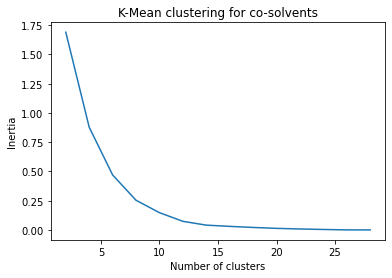

In [18]:
norm_scaler = MinMaxScaler()
X_cosolv = norm_scaler.fit_transform(df_cosolv.iloc[:,[1,2]])
center_num = list(range(2,30,2))
inertia = []
for i in center_num:
    kmeans = KMeans(n_clusters=i).fit(X_cosolv)
    inertia.append(kmeans.inertia_)
plt.plot(center_num, inertia)
plt.title('K-Mean clustering for co-solvents')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Here I see an elbow point around K=12, so K=12 will be used.

In [19]:
center_num=12
kmeans = KMeans(n_clusters=center_num).fit(X_cosolv)
df_cosolv['label'] = kmeans.labels_ + 80
df_cosolv.head()

C:\Users\leafblade\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt,label
Cosolv_1,0,7.0,0.00,0.0,0,0,0,0,1,1,80
Cosolv_2,0,4.0,2.77,0.0,0,0,0,0,1,1,90
Cosolv_3,0,10.0,15.00,0.0,0,0,0,0,1,1,81
Cosolv_4,0,4.0,5.00,1.0,0,0,0,0,1,1,82
Cosolv_5,0,3.0,0.00,0.0,0,0,0,0,1,1,86


Then we concatenate this two dataframes, and save the clustered features.

In [20]:
df_chem = pd.concat([df_surf, df_cosolv])
df_chem.head()

,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt,label
Surf_1,1,0.190909,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,3
Surf_2,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,46
Surf_3,1,0.272727,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,3
Surf_4,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,46
Surf_5,1,0.175000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.003891,3


In [21]:
df_chem.to_csv('ML_FinalProject_F20_Tongzhou Zeng_data_3_processed.csv')

## 3. Train models

### 3.1 Fill in features

We successfully extract the features, so now we are going to build the dataset for training. We first reload the processed property tables, and view their first 5 rows.

In [22]:
df_pb = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_1.csv',index_col = 0)
df_oil = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_2_processed.csv',index_col = 0)
df_chem = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_3_processed.csv', index_col = 0)

In [23]:
df_chem.head()

,issurf,NC,NEO,NPO,HG_SO4,HG_COO,HG_ABS,HG_IOS,HG_Nonionic,cnt,label
Surf_1,1,0.190909,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,3
Surf_2,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,46
Surf_3,1,0.272727,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,3
Surf_4,1,0.363636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001946,46
Surf_5,1,0.175000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.003891,3


In [24]:
df_oil.head()

,MW,EACN,Vm,density,TAN,active,PCA_1,PCA_2,PCA_3
Oil_1,230.000000,10.000000,283.513097,0.811250,0.100,0,138.261950,13.955987,351.598094
Oil_1 + 12% Oil_L,194.990578,7.714458,238.410456,0.817878,0.088,0,82.561553,13.199927,297.127604
Oil_2 + 21% Oil_A,283.870691,12.477616,321.939496,0.861833,0.158,0,240.469684,10.912869,375.823172
Oil_2 + 30% Oil_A,283.870691,12.477616,321.939496,0.861833,0.140,0,239.970654,10.894720,376.435571
Oil_3,310.000000,11.000000,353.881279,0.876000,2.080,1,379.704017,13.042844,222.551265


In [25]:
df_pb.head()

,Cat,Formulation,Oil
0,0,0.125%#Surf_79#0.125%#Surf_15#,Oil_4
1,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4
2,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4
3,1,0.1%#Surf_52#0.1%#Surf_69#,Oil_4
4,0,0.5%#Surf_52#0.5%#Surf_69#,Oil_4


Next for the main phase behavior dataframe, we need to allocate space for features. My designed features are 3 dense features describing the propeties of oil, and 92 sparse features charaterizing the concentration of each chemical cluster.

In [26]:
for i in range(3): # for oil we have 3 features
    df_pb['oil_pca_' + str(i + 1)] = 0
for j in range(92): # for chemical we have 80+12=92 clusters
    df_pb['chemical_cluster_' + str(j)] = 0
df_pb.head()

,Cat,Formulation,Oil,oil_pca_1,oil_pca_2,oil_pca_3,chemical_cluster_0,chemical_cluster_1,chemical_cluster_2,chemical_cluster_3,...,chemical_cluster_82,chemical_cluster_83,chemical_cluster_84,chemical_cluster_85,chemical_cluster_86,chemical_cluster_87,chemical_cluster_88,chemical_cluster_89,chemical_cluster_90,chemical_cluster_91
0,0,0.125%#Surf_79#0.125%#Surf_15#,Oil_4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.1%#Surf_52#0.1%#Surf_69#,Oil_4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.5%#Surf_52#0.5%#Surf_69#,Oil_4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we iterate each row to fill in blanks. For chemicals, we put the total concentration for each cluster.

In [27]:

for i in range(len(df_pb)):
    # for oil
    oil_name = df_pb.loc[i, 'Oil']  # find the name of the oil
    for j in range(3):
        # for each principal component, find the cell in the oil_pca table with the oil name
        df_pb.loc[i, 'oil_pca_' + str(j + 1)] = df_oil.loc[oil_name, 'PCA_' + str(j + 1)]
    
    # for chemical
    chem_list = df_pb.loc[i, 'Formulation'].split('#') # it will be a list of [conc1, name1, conc2, name2....]
    num = len(chem_list)//2 # find out how many different kind of chemicals
    flag = False
    for j in range(1, num + 1): # for each of the chemical included
        idx1 = 2 * (j - 1)      # index for its concentration in the chem_list
        idx2 = 2 * (j - 1) + 1  # index for its name in the chem_list
        concentrationj = float(chem_list[idx1][:-1]) # extract its concentration, [:-1] means getting rid of "%"
        chemj = chem_list[idx2] # extract its name
        clus = df_chem.loc[chemj, 'label'] # use the name to find which cluster it belongs to
        df_pb.loc[i, 'chemical_cluster_' + str(int(clus))] += concentrationj # we add the concentration in the cell
        

In [28]:
df_pb.head()

,Cat,Formulation,Oil,oil_pca_1,oil_pca_2,oil_pca_3,chemical_cluster_0,chemical_cluster_1,chemical_cluster_2,chemical_cluster_3,...,chemical_cluster_82,chemical_cluster_83,chemical_cluster_84,chemical_cluster_85,chemical_cluster_86,chemical_cluster_87,chemical_cluster_88,chemical_cluster_89,chemical_cluster_90,chemical_cluster_91
0,0,0.125%#Surf_79#0.125%#Surf_15#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.1%#Surf_52#0.1%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.5%#Surf_52#0.5%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we save the data frame in case we do not want to redo it.

In [29]:
df_pb.to_csv('ML_FinalProject_F20_Tongzhou Zeng_data_1_processed.csv')

### 3.2 Model Training

Finally its time to train model! We load the dataset with features.

In [30]:
df = pd.read_csv('ML_FinalProject_F20_Tongzhou Zeng_data_1_processed.csv',index_col = 0)
df.head()

,Cat,Formulation,Oil,oil_pca_1,oil_pca_2,oil_pca_3,chemical_cluster_0,chemical_cluster_1,chemical_cluster_2,chemical_cluster_3,...,chemical_cluster_82,chemical_cluster_83,chemical_cluster_84,chemical_cluster_85,chemical_cluster_86,chemical_cluster_87,chemical_cluster_88,chemical_cluster_89,chemical_cluster_90,chemical_cluster_91
0,0,0.125%#Surf_79#0.125%#Surf_15#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.125%#Surf_52#0.125%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.1%#Surf_52#0.1%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.5%#Surf_52#0.5%#Surf_69#,Oil_4,551.665553,15.638571,443.961419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separate the predictor and response

In [31]:
X = df.iloc[:, 3:]
y = df.iloc[:, 0]

Train test split

In [32]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.2, random_state = 19961012)
#X_train, X_vali, y_train, y_vali = train_test_split(X_tr, y_tr, test_size = 0.25, random_state = 19961012)

We first try a logistic regression model as our base case.

accuracy:  0.686
PR AUC:  0.603


C:\Users\leafblade\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


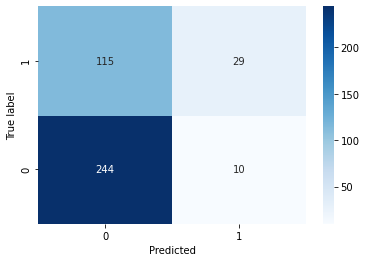

In [33]:
classifier = LogisticRegression()

# for logistic regression we need to normalize the features
norm_scaler = MinMaxScaler()
X_tr_n = norm_scaler.fit_transform(X_tr)
X_test_n = norm_scaler.transform(X_test)

classifier.fit(X_tr_n, y_tr)
y_pred = classifier.predict(X_test_n)
y_predprob = classifier.predict_proba(X_test_n)[:,1]
present_result(y_test, y_pred, y_predprob)

We see it does not work well. It almost predict every thing 0. But logistic regression is just a basecase. The simple linear classifier will underfit this complicated dataset without tedious and detailed feature engineering process. Next I will try random forest, another popular classification algorithm. Random forest generally works good for the data size on this order by experience. The tree model generally have low bias and its double randomness (bootstrap + random feature selection) will reduce the variance.

accuracy:  0.786
PR AUC:  0.802


C:\Users\leafblade\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


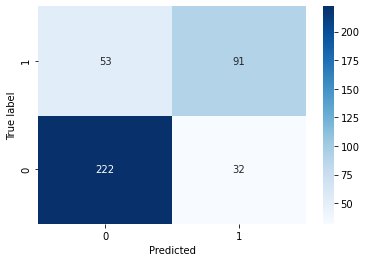

In [34]:
classifier = RandomForestClassifier()

# for random forest, we do not need to normalize features

classifier.fit(X_tr, y_tr)
y_pred = classifier.predict(X_test)
y_predprob = classifier.predict_proba(X_test)[:,1]
present_result(y_test, y_pred, y_predprob)

We can see random forest works much better than logistic regression. 


## 4. Hyperparameter Tuning

Here I tried hyperparameter tuning using cross validation (GridSearchCV package) on the training set. The process is tedious, the code is pretty repeatitive, and the execution time is long. Here I just show the final model after hyperparameter tuning.

accuracy:  0.799
PR AUC:  0.825


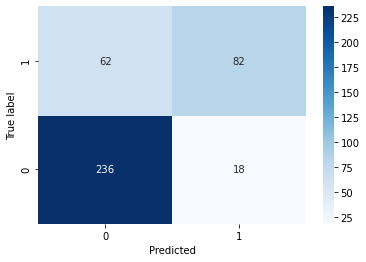

In [35]:
# after CV hyperparameter tuning on training set

classifier = RandomForestClassifier(criterion = 'entropy', max_depth=19, min_samples_split=4, n_estimators=125, oob_score=True)

# for random forest, we do not need to normalize features

classifier.fit(X_tr, y_tr)
y_pred = classifier.predict(X_test)
y_predprob = classifier.predict_proba(X_test)[:,1]
present_result(y_test, y_pred, y_predprob)

After hyperparameter tuning, the accuracy and PR AUC are around 0.8, which is much better than random guess. 

In this project, the raw data is not as nice as that of homework problems, which already give numerical values of every predictor variable. For this project, the raw data is in a "relational database"-like structure. This workflow demonstrates the process of solving this problem from scratch, including data cleaning, data preprocessing, feature building, model training, metrics selection, and hyperparameter tuning. For the final random forest model, the accuracy and PR AUC are around 0.8, which is pretty good for my purpose. 

I hope this was helpful,

*Tongzhou Zeng*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
